<a href="https://colab.research.google.com/github/gouri-r/ML/blob/main/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURAL STYLE TRANSFER

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

uploaded=files.upload()
content=plt.imread('Building.jpg')
uploaded=files.upload()
style=plt.imread('Starry_Night.jpg')

Saving Building.jpg to Building.jpg


Saving Starry_Night.jpg to Starry_Night (1).jpg


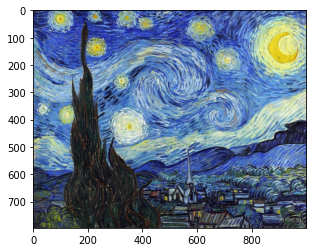

In [ ]:
from matplotlib.pyplot import imshow

imshow(style)

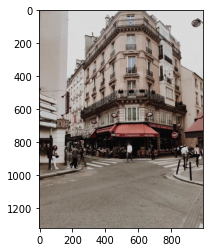

In [ ]:
imshow(content)

Convert images into arrays of shape(none,none,none,3) to match the model we're going to use.

In [ ]:
import tensorflow as tf 

def load_image(image):
  image=plt.imread(image)
  img = tf.image.convert_image_dtype(image,tf.float32)
  img = tf.image.resize(img,[400,400])
  img=img[tf.newaxis,:]
  return img

In [ ]:
content=load_image('Buildings.jpg')
style=load_image('Starry_Night.jpg')

content.shape,style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable=False

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

#  Why to Use Intermediate Levels Output?
At higher level a network is trained to perform image classification,it should understand the image.This requires to take raw pixels and convert these pixels into complex understanding of features.

The following function gets layer names as input and selects the layer's output.

"model = " line creates model with single input (vgg.input) and gives one or more outputs depending on number of names in layer_names list. 

In [ ]:
def build_model(layer_names,model):
  outputs=[model.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input],outputs)
  return model

result[b,c,d] = input[b,i,j,c] * input[b,i,j,d]

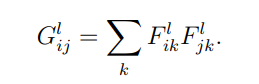

In [ ]:
def gram_matrix(input):
  result = tf.linalg.einsum('bijc,bijd->bcd', input, input)
 # input_shape = tf.shape(input)
 # num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result    #/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  build_model(style_layers + content_layers,vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content))

In [ ]:
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [ ]:
image = tf.Variable(content)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
import numpy as np
import PIL.Image
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

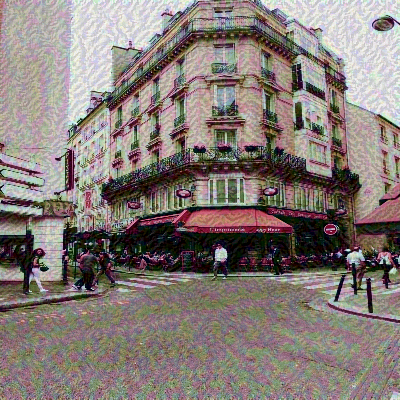

In [ ]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

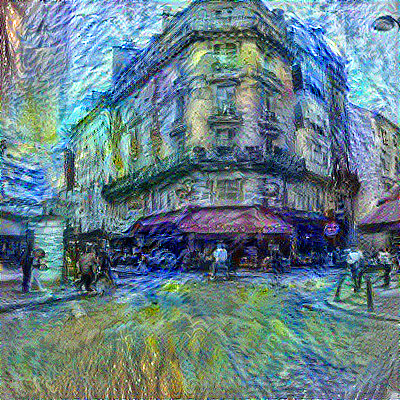

KeyboardInterrupt: ignored

In [ ]:
import IPython.display as display

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    train_step(image)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))